In [1]:
import warnings
from pathlib import Path
import json
import re

import numpy as np  

# Support for interactive widgets
from IPython.display import *
from ipywidgets import Dropdown

# %matplotlib widget 
import matplotlib.pyplot as plt

from SEDFit.sed import SEDFit

warnings.filterwarnings("ignore", "Using UFloat objects with std_dev==0 may give unexpected results.", category=UserWarning)
from uncertainties import ufloat
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.simbad import Simbad
from astroquery.vizier import Vizier
from astroquery.gaia import Gaia

from deblib.constants import M_sun, R_sun
from deblib.stellar import log_g

from libs import extinction
from libs.pipeline import get_teff_from_spt

### Select our target and get its known information

In [2]:
default_target = "CW Eri"
targets_config_file = Path.cwd() / "config" / "fitting-a-sed-targets.json"
with open(targets_config_file, mode="r", encoding="utf8") as f:
    full_dict = json.load(f)
targets_cfg = { k: full_dict[k] for k in full_dict if full_dict[k].get("enabled", True) }

options = [(f"{t}" + (" *" if c.get("exclude", False) else ""), t) for t, c in targets_cfg.items()]
target_selection = Dropdown(options=options, value=default_target, description="Targets:")
display(target_selection)

Dropdown(description='Targets:', index=17, options=(('V436 Per', 'V436 Per'), ('V539 Ara', 'V539 Ara'), ('MU C…

In [3]:
target = target_selection.value
target_config = targets_cfg[target]
target_config.setdefault("loggA", log_g(target_config["MA"] * M_sun, target_config["RA"] * R_sun).n)
target_config.setdefault("loggB", log_g(target_config["MB"] * M_sun, target_config["RB"] * R_sun).n)

# Additional data on the target populated with lookups
target_data = { }
target_data["label"] = target_config.get("label", target)
target_data["search_term"] = target_config.get("search_term", target)

_simbad = Simbad()
_simbad.add_votable_fields("sp", "ids")
if _tbl := _simbad.query_object(target_data["search_term"]):
    target_data["ids"] = np.array(re.findall(r"(Gaia DR3|V\*|TIC|HD|HIP|2MASS)\s+(.+?(?=\||$))", _tbl["ids"][0]),
                                    dtype=[("type", object), ("id", object)])
    print(f"IDs:", ", ".join(f"{i['type']} {i['id']}" for i in target_data["ids"]))
    target_data["spt"] = _tbl["sp_type"][0]
    print(f"SpT:", target_data["spt"])

IDs: HIP 14273, Gaia DR3 5152756553745197952, TIC 98853987, 2MASS J03035994-1744159, HD 19115, V* BV  1000, V* CW Eri
SpT: F2V


In [4]:
# Let's get the Gaia DR3 data on this here object
_gaia_dr3_id = target_data["ids"][target_data["ids"]["type"] == "Gaia DR3"]["id"][0]
if _job := Gaia.launch_job(f"SELECT TOP 1 * FROM gaiadr3.gaia_source WHERE source_id = {_gaia_dr3_id}"):
    _tbl = _job.get_results()
    target_data["parallax_mas"] = ufloat(_tbl["parallax"][0], _tbl["parallax_error"][0])
    target_data["skycoords"] = _coords = SkyCoord(ra=_tbl["ra"][0] * u.deg, dec=_tbl["dec"][0] * u.deg,
                                                  distance=1000 / _tbl["parallax"][0] * u.pc, frame="icrs")
    print(f"{target} SkyCoords are {_coords} (or {_coords.to_string('hmsdms')})")
    target_data["bp_rp"] = _tbl["bp_rp"][0]
    target_data["phot_g_mean_mag"] = _tbl["phot_g_mean_mag"][0]
    target_data["ruwe"] = _tbl["ruwe"][0]

CW Eri SkyCoords are <SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    (46.00004676, -17.73777489, 190.91243808)> (or 03h04m00.01122245s -17d44m15.98959459s)


In [5]:
# Lookup the TESS Input Catalog (8.2) for starting "system" Teff and logg values
target_data["teff_sys"] = get_teff_from_spt(target_data["spt"]) or ufloat(5700, 0)
target_data["logg_sys"] = ufloat(4.0, 0)
if _tbl := Vizier(catalog="IV/39/tic82").query_object(target_data["search_term"], radius=0.1 * u.arcsec):
    if _row := _tbl[0][_tbl[0]["TIC"] in target_data["ids"][target_data["ids"]["type"] == "TIC"]["id"]]:
        # Teff may not be reliable - only use it if it's consistent with the SpT
        if target_data["teff_sys"].n-target_data["teff_sys"].s < (_row["Teff"] or 0) < target_data["teff_sys"].n+target_data["teff_sys"].s:
            target_data["teff_sys"] = ufloat(_row["Teff"], _row.get("s_Teff", None) or 0)
        if (_row["logg"] or 0) > 0:
            target_data["logg_sys"] = ufloat(_row["logg"], _row.get("s_logg", None) or 0)

# Other priors will likely come out of light curve fitting with JKTEBOP - get from config for now
target_data["k"] = ufloat(target_config.get("k"), target_config.get("k_err", 0) or 0)
# If from LC fit we may also need to consider l3; lA=(1-l3)/(1+(LB/LA)) & lB=(1-l3)/(1+1/(LB/LA))
target_data["light_ratio"] = ufloat(10**(target_config.get("logLB", 1) - target_config.get("logLA", 1)), 0)
target_data["teff_ratio"] = (target_data["light_ratio"] / target_data["k"]**2)**0.25

print(f"{target} system values from lookup and LC fitting:")
for p, unit in [("teff_sys", u.K), ("logg_sys", u.dex), ("k", None), ("light_ratio", None), ("teff_ratio", None)]:
    print(f"{p:>12s} = {target_data[p]:.3f} {unit or u.dimensionless_unscaled:unicode}")

CW Eri system values from lookup and LC fitting:
    teff_sys = 6861.000+/-226.500 K
    logg_sys = 3.788+/-0.105 dex
           k = 0.704+/-0.001 
 light_ratio = 0.420+/-0 
  teff_ratio = 0.960+/-0.001 


In [6]:
rv = 3.1
for val, flags in extinction.get_ebv(target_data["skycoords"], rv=rv):
    if val and not np.isnan(val) and flags.get("converged", False):
        av = val * rv
        print(f"Found extinction with {flags['source']}: E(B-V) = {val:.6f}, giving av={av:.6f}")
        break

Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.
Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 25.054 s
  pix_info:   0.371 s
   samples:  14.111 s
      best:   2.796 s
       nan:   0.021 s
      sort:   7.669 s
       idx:   0.086 s
Found extinction with get_bayestar_ebv: E(B-V) = 0.009960, giving av=0.030876


In [7]:
grid_type = "btsettl" # paper states 400 < Teff < 100,000, -0.5 < logg < 5.5, -1.5 < [M/H] < 0.5
# grid_type = "kurucz" # paper implies 2,000 <= Teff <= 200,000
# grid_type = "coelho" # paper states 3000 <  Teff < 25,000; -0.5 < logg < 5.5
# grid_type = "phoenix" # paper states 2300 <= Teff <= 12,000; 0 <= logg <= 6, -4 <= [Fe/H] <= 1

(cache_dir := Path(".cache/.sedfit/")).mkdir(parents=True, exist_ok=True)

x = SEDFit(ra=target_data["skycoords"].ra,
           dec=target_data["skycoords"].dec, 
           nstar=2,
           grid_type=grid_type,
           filename=str(cache_dir / (re.sub(r"[^\w\d-]", "-", target.lower()) + ".fits")))

x.addguesses(dist=target_data["skycoords"].distance.to(u.pc).value,
             av=av,
             teff=[target_data["teff_sys"].n, target_data["teff_sys"].n * target_data["teff_ratio"].n],
             logg=[target_data["logg_sys"].n] * 2)

x.addrange(logg=[target_data["logg_sys"].n - 0.25, target_data["logg_sys"].n + 0.25])

Gaia DR3 distance towards this source is 190.9 pc
3 sigma uncertainty in distance is 188.8 - 193.1 pc
RUWE is 1.029
Maximum Av along the line of sight is 0.121


/home/steveo/projects/main/platodebcat/.platodebcat/lib/python3.11/site-packages/dust_extinction/helpers.py:12: SpectralUnitsWarning: x has no units, assuming x units are inverse microns
  warnings.warn(


In [8]:
# Handle any exclusions
exclusions = np.array([], dtype=str)
idx = np.where(np.isin(x.sed['sed_filter'], test_elements=exclusions, invert=True))[0]

pars = x.fit(use_gaia=True,
             fitdist=True,
             fitav=False,
             fitfeh=False,
             idx=idx,
             teffratio=target_data["teff_ratio"].nominal_value,
             teffratio_error=target_data["teff_ratio"].std_dev,
             radiusratio=target_data["k"].nominal_value,
             radiusratio_error=target_data["k"].std_dev)

In [9]:
print(f"Distance: {x.getdist()} pc")
print(f"AV: {x.getav()} mag")
print(f"Radius: {x.getr()} Rsun")
print(f"Teff: {x.getteff()} K")
print(f"Log g: {x.getlogg()}")
print(f"Fe/H: {x.getfeh()}")
print(f"Chi squared: {x.getchisq()}")

Distance: 191.3936933575034 pc
AV: 0.030875999309867622 mag
Radius: [1.954806406777316, 1.375707896222845] Rsun
Teff: [7238.330940513078, 6941.121450222794] K
Log g: [3.538399934768677, 3.538399934778119]
Fe/H: 0.0
Chi squared: 50.48677411430885


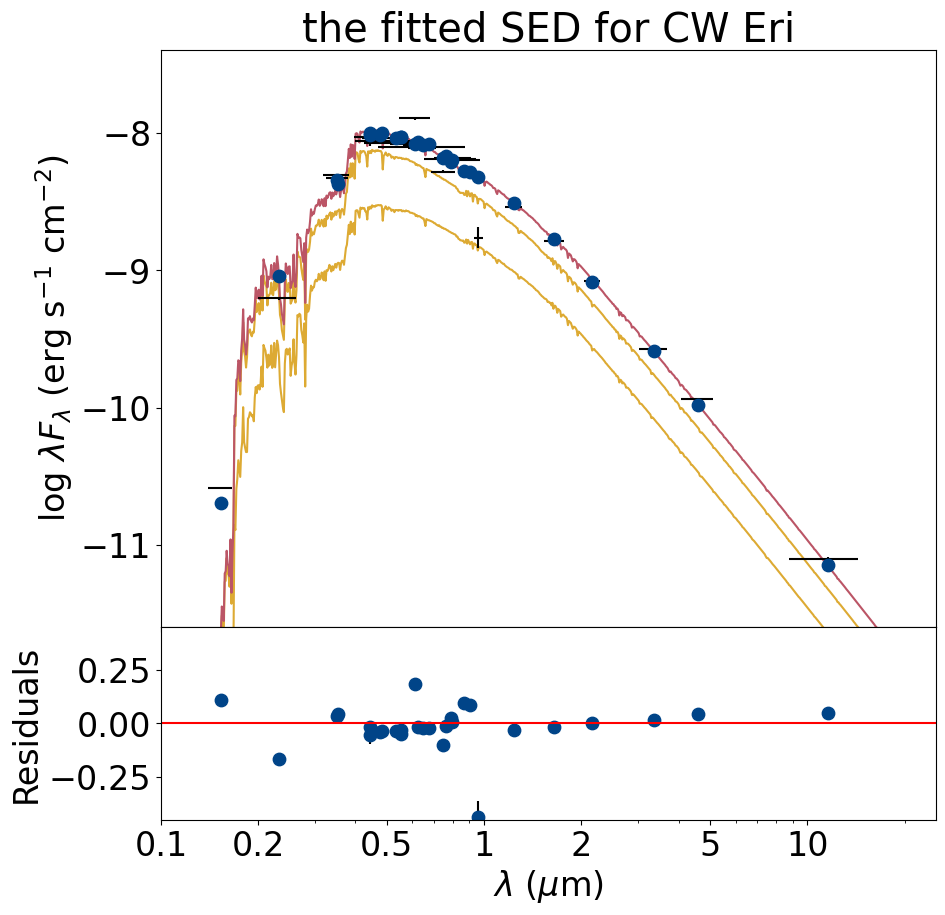

In [10]:
ax=x.makeplot(idx=idx, getplot=True)
ax[0].set_title(f"the fitted SED for {target_config.get('label', target)}")
ax[1].set_ylim(-0.45, 0.45)
plt.show()

In [11]:
x.sed["model"] = x.mags
x.sed[idx]

index,sed_filter,la,width,flux,eflux,model
,,Angstrom,Angstrom,Angstrom,erg / (Angstrom s cm2),
int64,bytes21,float64,float64,float64,float64,float64
0,GALEX.FUV,1529,134.0,-10.5837,0.0098,-10.69189205576752
3,GALEX.NUV,2312,308.0,-9.20321,0.0087,-9.038733461108398
6,Cousins.U,3502,319.0,-8.30459,0.0087,-8.340373378716297
7,SDSS.u,3519,277.0,-8.33003,0.0087,-8.372459542425425
9,Cousins.B,4425,464.0,-8.02913,0.0087,-8.013176194609061
10,Johnson.B,4442,445.0,-8.05349,0.043,-7.999971691839339
12,PAN-STARRS.PS1.g,4776,583.0,-8.05577,0.0087,-8.014953204698822
13,SDSS.g,4820,622.0,-8.03304,0.0087,-7.997447208812668
